# Data Science Project: Final Report

Olivia Liang  
Tianyu Zou  
Tommy Xie  

[github link](https://github.com/lsqolivia/Final-Report-34)

## Introduction

Understanding how players interact with online game environments has become increasingly important for researchers who aim to improve user engagement and manage digital resources effectively. In this project, we analyze data collected from a research Minecraft server operated by a Computer Science research group at UBC.   
Our analysis focuses on predicting which players are most likely to subscribe to the project's game-related newsletter. Newsletter subscription serves as a meaningful indicator of deeper engagement, as players who opt in typically show higher interest in the project and a stronger connection to the research community.    
  
We aim to answer the following predictive question in this project:  
**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**  
  
By examining the characteristics and behaviors of different players, we aim to identify the features most predictive of subscription decisions. Understanding these relationships will help stakeholders better target communication efforts and develop strategies for recruiting and retaining highly engaged players.

### Selected Question

In particular, we will use **experience**, and **played_hours** as predictors to predict **subscribe**.  
This is a **KNN classification** problem since the response variable `subscribe` is categorical.  

## Data Description

The dataset contains **196 observations** and **7 variables**. The key variables are:

+ `experience`: character that indicates the player’s experience level, categorized as `Pro`, `Veteran`, `Amateur`, `Regular`, or `Beginner`.  
+ `subscribe`: logical that shows whether the player subscribed to game updates (`TRUE` or `FALSE`).  
+ `hashedEmail`: character that stores the hashed email ID of each player.  
+ `played_hours`: double (numeric) that records total playtime in hours, ranging from 0 to 99.
+ `name`: a character variable containing each player's in-game username.
+ `gender`: a character variable indicating the player's self-identified gender.
+ `age`:a numeric variable that representing the player's age in years.
  
**Each row in the dataset corresponds to one unique player on the Minecraft research server.**

### potential issues

1. The hashedEmail column is not interpretable and can be ignored.

2. Experience is categorical; it must be converted into numeric form for modelling.

3. Minor gender categories (Agender, Other, Two-Spirited) have very small counts and could be merged with “Other.”

## Methods & Results

After veiwing the data we decide to use Classification with K-nearest neighbors.

**Loads Data**

Loaded the dataset from a Google Drive link using read_csv().

In [1]:
library(tidyverse)
url = 'https://drive.google.com/uc?export=download&id=1CrHpOItZ_dz1WRDVQdmhn_aSymEQrSBy'
players <- read_csv(url)
head(players)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Wrangle & Clean**

We removed rows with missing age values and filtered out players with zero playtime, since these rows provide no behavioural information for modelling. The subscribe variable was converted to a factor for classification. Only relevant variables were retained for simplicity and consistency with the planned analysis.

In [2]:
clean_players <- players |>
select(c(1,2,4,6,7))

clean_players |>
map_lgl(anyNA)

clean_players <- clean_players |>
filter(played_hours>0)

clean_players$subscribe <- factor(clean_players$subscribe)

experience    subscribe played_hours       gender          Age 
       FALSE        FALSE        FALSE        FALSE         TRUE

**Exploratory Data Analysis**

In [3]:
# Count players in each experience level
clean_players |> 
  group_by(experience) |>
  summarize(count = n())

# Count players by subscription status
clean_players |> 
  group_by(subscribe) |>
  summarize(count = n())

# Summary of numerical ranges
clean_players |> 
  summarize(max_played = max(played_hours, na.rm = TRUE),
            min_played = min(played_hours, na.rm = TRUE))

experience,count
<chr>,<int>
Amateur,35
Beginner,19
Pro,11
Regular,20
Veteran,26


subscribe,count
<fct>,<int>
FALSE,25
TRUE,86


max_played,min_played
<dbl>,<dbl>
223.1,0.1


To understand the structure of the dataset, we first summarized the distribution of the categorical variables. The experience variable contains five groups: **Amateur (35 players)**, **Beginner (19)**, **Regular (20)**, **Veteran (26)**, and **Pro (11)**. Subscription status is also imbalanced, with **86 subscribers** and **25 non-subscribers**. This imbalance is important for classification and later motivated the use of upsampling. We also examined the quantitative predictor played_hours, which ranges from **0.1 to 223.1 hours**, indicating a wide spread and the presence of extreme values. Including these counts and ranges provides a clearer context for the modelling stage and helps assess class balance and predictor scale.

**Data Visualizations**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


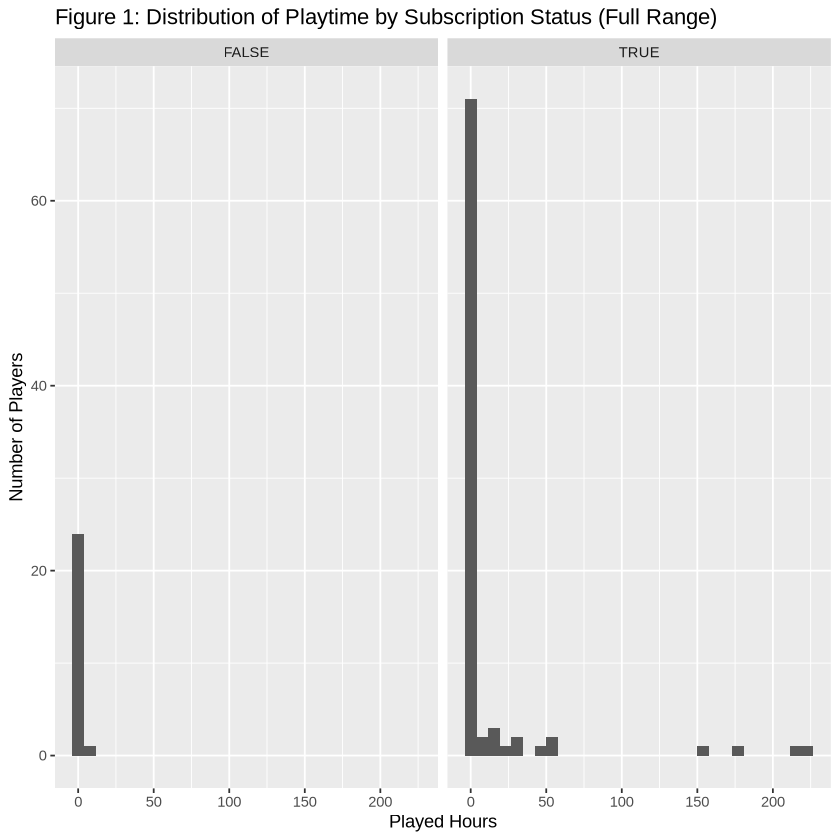

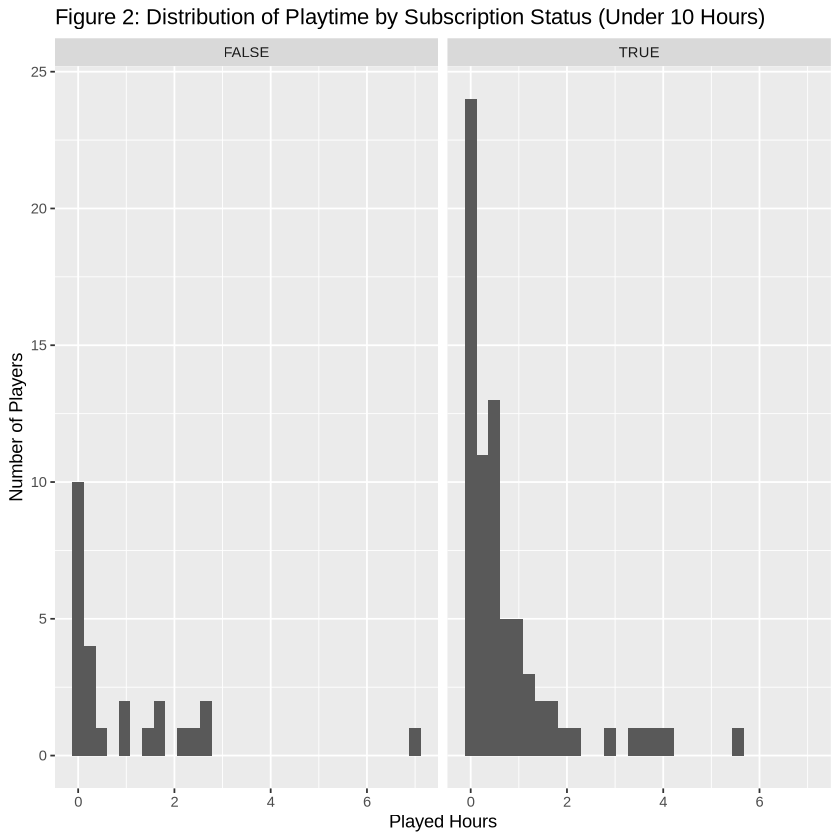

In [4]:
ggplot(clean_players, aes(x=played_hours)) +
geom_histogram() + 
facet_grid(cols = vars(subscribe)) +
labs(title = "Figure 1: Distribution of Playtime by Subscription Status (Full Range)",
     x = "Played Hours",
     y = "Number of Players")

clean_players |> filter(played_hours <= 10) |>
ggplot(aes(x=played_hours)) + geom_histogram() +
facet_grid(cols = vars(subscribe)) +
labs(title = "Figure 2: Distribution of Playtime by Subscription Status (Under 10 Hours)",
     x = "Played Hours",
     y = "Number of Players")

Figure 1 shows that playtime is highly skewed, with a few players having very high total hours.

Figure 2 focuses on players with 10 hours or less and shows that subscribers are concentrated in this low-playtime range, while non-subscribers are more spread out.

This suggests that casual players are more likely to subscribe, so played_hours is a relevant predictor for subscription.

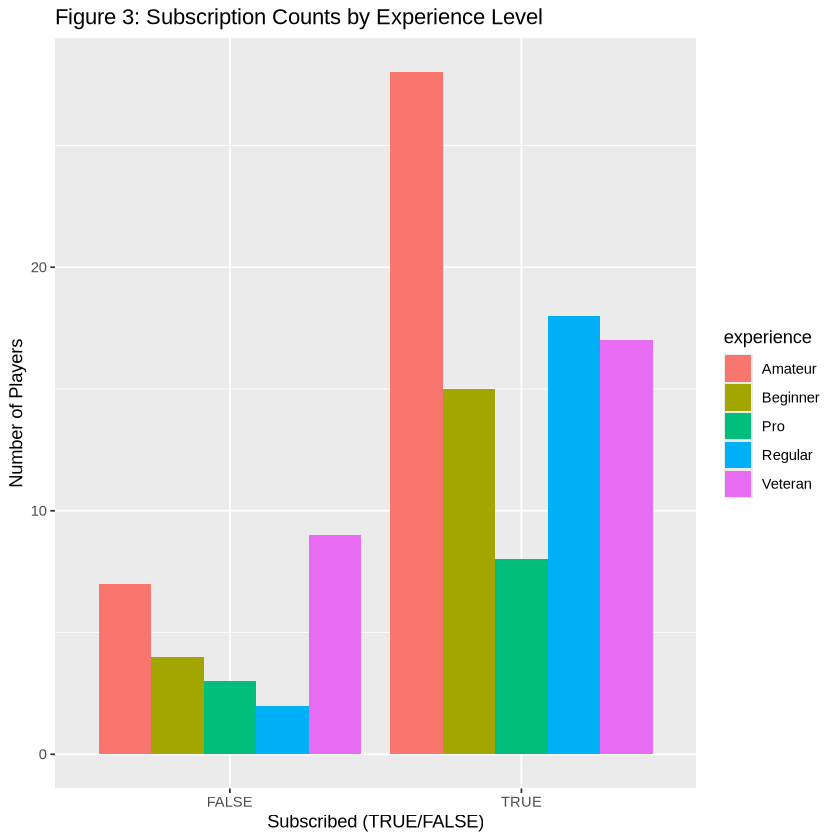

In [5]:
ggplot(clean_players, aes(x=subscribe)) +
geom_bar(aes(fill=experience), position="dodge") +
labs(title = "Figure 3: Subscription Counts by Experience Level",
     x = "Subscribed (TRUE/FALSE)",
     y = "Number of Players")

Figure 3 shows that Veteran and Amateur players show more subscriptions, while Beginners and Pros subscribe less often.
Because subscription patterns differ across experience categories, experience appears to be a meaningful predictor.

**Data Analysis -- Model Building (KNN Classification)**

To use experience as a predictor in the KNN classifier, it must be converted into a numeric format. We chose ordinal encoding instead of one-hot encoding because the experience levels in this dataset have a natural order (Beginner → Regular → Amateur → Veteran → Pro). Assigning them values 1 through 5 preserves this ordering and reflects how player experience progresses. One-hot encoding would create five separate binary columns, which can distort distance calculations in KNN and make players with similar experience appear farther apart than they actually are. Ordinary encoding keeps the variable in a single column and allows KNN to treat experience differences in a more meaningful and consistent way.

Next, we created a modelling dataset that keeps only the relevant variables for the classifier: subscribe (response), played_hours, and the new experience_numeric predictor. This dataset forms the input for KNN.

We then split the data into 75% training and 25% testing, using strata = subscribe to preserve the proportion of TRUE/FALSE labels in both sets. This ensures that the classifier is evaluated fairly and avoids imbalance issues during model training.

In [6]:
library(tidymodels)
library(kknn)
set.seed(123)

experience_encoded = factor(clean_players$experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"), ordered = TRUE)

experience_numeric = as.numeric(experience_encoded)

ordinary_players <- clean_players |>
mutate(experience_numeric = experience_numeric) |>
select (c(2,3,6))
head(ordinary_players)

players_split <- initial_split(ordinary_players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



subscribe,played_hours,experience_numeric
<fct>,<dbl>,<dbl>
TRUE,30.3,5
TRUE,3.8,4
TRUE,0.7,2
TRUE,0.1,3
TRUE,0.1,2
TRUE,1.6,4


We built a modelling recipe that prepares the predictors for KNN classification. Because the number of subscribers and non-subscribers (TRUE/FALSE) is not balanced, we added an upsampling step using step_upsample(). This replicates the minority class so that both classes appear in roughly equal numbers in the training data. Balancing the classes is helpful for KNN, which relies on neighbourhood voting—when one class is much smaller, it can easily be out-voted even when it is the correct label.

After upsampling, the recipe scales and centers the predictors so that played_hours and experience_numeric are on similar numeric ranges, which is required for distance-based methods like KNN.

We then defined a KNN classifier with neighbours = tune() and used 5-fold cross-validation to evaluate k values from 1 to 10. The tuning process tests each k and reports its accuracy so we can select the best-performing value.

In [11]:
set.seed(1123)

library(themis)

players_recipe <- recipe(subscribe ~ played_hours + experience_numeric, data = players_train) |>
step_upsample(subscribe, over_ratio = 1) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_grid <- tibble(neighbors = 1:10)

players_folds <- vfold_cv(players_train, v = 5, strata = subscribe)

players_tune_fit <- workflow() |> 
add_recipe(players_recipe) |>
add_model(players_tune) |>
tune_grid(resamples = players_folds, grid = k_grid)

players_tune_accuracy  <- players_tune_fit |>
collect_metrics() |>
filter(.metric == "accuracy") |>
select (neighbors, mean) |> 
arrange(desc(mean))
players_tune_accuracy 

neighbors,mean
<int>,<dbl>
1,0.5243137
2,0.5243137
7,0.4969118
8,0.4969118
10,0.4867157
9,0.4631863
5,0.4286275
6,0.4286275
3,0.4277941


We selected k = 1 because it was the smallest k that achieved the highest cross-validated accuracy during tuning.

**Visualization of the Analysis**

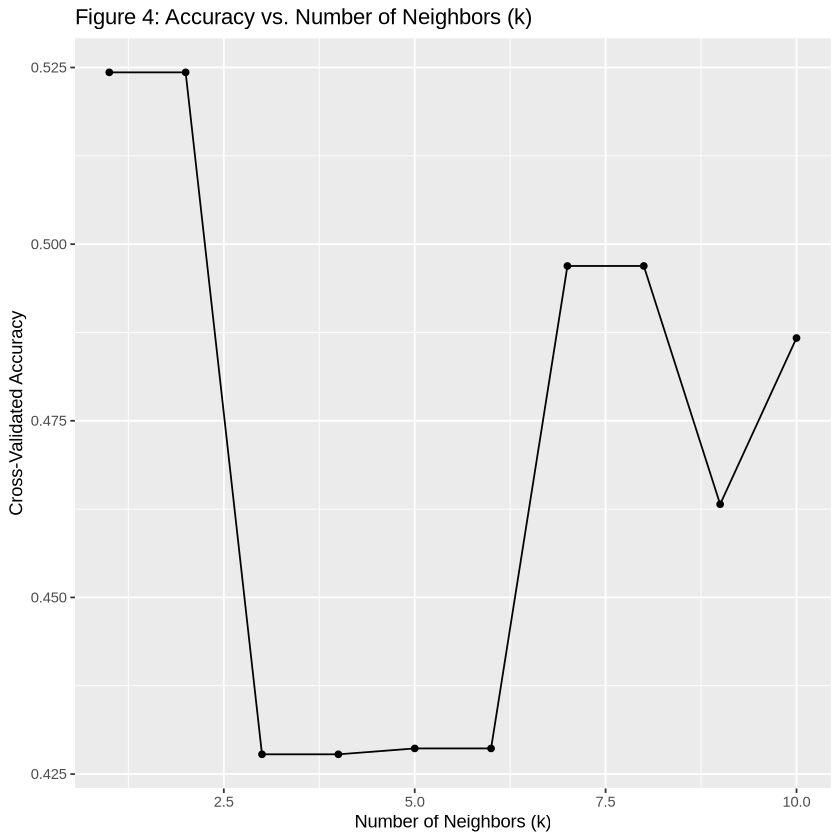

In [12]:
accuracy_vs_k <- players_tune_accuracy  |>
ggplot(aes(x = neighbors, y = mean)) +
geom_line() +
geom_point() +
labs(title = "Figure 4: Accuracy vs. Number of Neighbors (k)",
     x = "Number of Neighbors (k)",
     y = "Cross-Validated Accuracy")
accuracy_vs_k

.pred_class,subscribe,played_hours,experience_numeric
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,30.3,5
FALSE,TRUE,3.8,4
TRUE,TRUE,0.5,2
TRUE,TRUE,0.6,3
FALSE,FALSE,0.1,4
TRUE,TRUE,0.3,2


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6206897
kap,binary,0.2799097


          Truth
Prediction FALSE TRUE
     FALSE     6   10
     TRUE      1   12

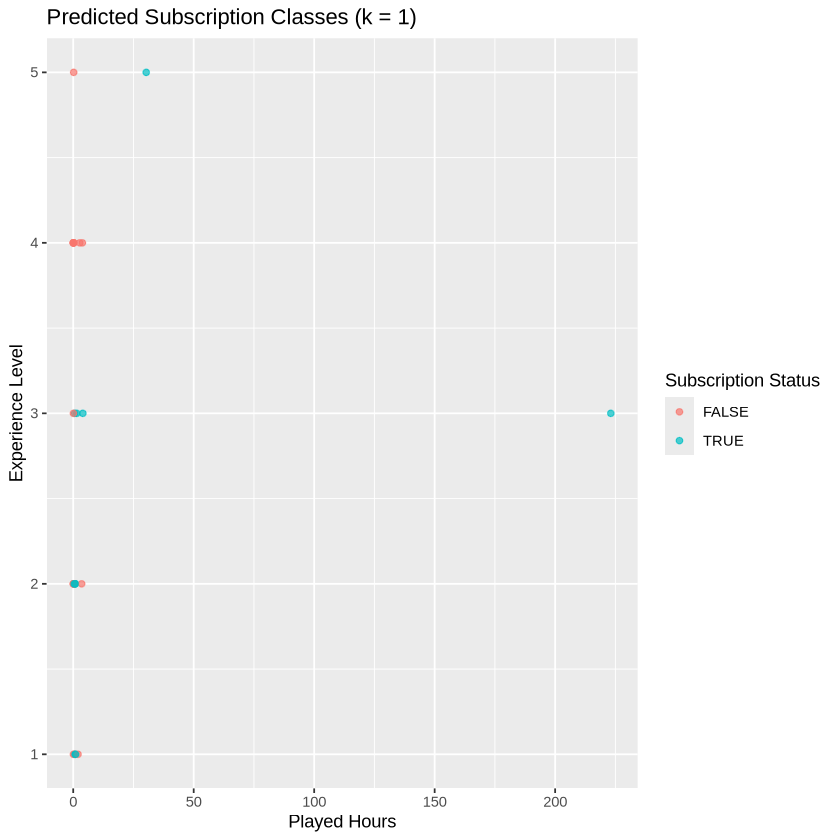

In [14]:
final_wf <- workflow() |>
add_recipe(players_recipe) |>
add_model(nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")) |>
fit(players_train)

test_predictions <- predict(final_wf, players_test) |>
bind_cols(players_test)

metrics <- test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

conf_mat <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

head(test_predictions)
metrics
conf_mat

test_set <- test_predictions |>
mutate(predicted = .pred_class) |>
ggplot(aes(x = played_hours, y = experience_numeric, color = .pred_class)) +
geom_point(alpha = 0.7) +
labs(title = "Predicted Subscription Classes (k = 1)",
     x = "Played Hours",
     y = "Experience Level",
    color = "Subscription Status")
test_set

The classifier showed mixed performance. Precision for the TRUE class was high (0.923), meaning that when the model predicted a player would subscribe, it was correct most of the time. However, recall was low (0.545), indicating that the model missed many real subscribers. In other words, the classifier is conservative in predicting TRUE: it rarely predicts a subscriber incorrectly, but it fails to capture nearly half of the actual subscribers. This pattern suggests that the predictors used (played_hours and experience) help identify strong subscribers but are less effective for detecting the full range of subscription behaviour.

## Discussion

Our final model selected **k = 1**, which gave the highest accuracy after upsampling. The test accuracy was **62%**, meaning the classifier performed moderately but not strongly. The confusion matrix showed the model predicted subscriber status unevenly: precision for the TRUE class was high **(0.923)**, but recall was much lower **(0.545)**. The model was good at confirming a subscription when it predicted TRUE, but it failed to detect many actual subscribers. This pattern suggests that **played_hours** and **experience** offer only partial predictive value.

These results do not fully match what we expected. From Figures 1–3, we anticipated a clearer relationship:

Many TRUE subscribers clustered in the low-playtime range (≤10 hours), suggesting casual players subscribe more often.

Veteran and Amateur players tended to subscribe more than Beginners or Pros.

Experience categories showed visible differences in subscription behaviour.

Because the visual patterns looked strong, we expected the model to learn these differences more effectively. Before upsampling, the classifier reached 77% accuracy, but it did so by predicting “TRUE” for nearly everyone. Once we balanced the classes, the true performance appeared and dropped to around 62%. This confirmed that the earlier accuracy was misleading and highlighted the difficulty of this prediction task.

Even with modest performance, the model still supports our main finding: **casual players and mid-experience groups are more likely to subscribe**. Both the exploratory plots and model behaviour pointed to this trend. The classifier reliably identified strong subscribers but struggled with the more ambiguous cases.

These findings can still guide practical decisions. The team might focus outreach on newer or light-playtime users, design newsletters with early-stage content, or build engagement strategies that encourage occasional players to stay connected. Understanding that casual players are a key audience can help shape more effective communication and recruitment efforts.

There are clear directions for further work. Adding more behavioural features, such as detailed movement logs, activity patterns, or session timing, may meaningfully strengthen prediction. A longitudinal analysis of subscription behaviour could show whether sign-ups reflect initial interest or continued involvement. It may also help to model subscription quality (e.g., open rates or link interactions) rather than treating it as a single TRUE/FALSE outcome. These extensions could offer a more complete view of how players engage with game-related communication.